In [4]:
! pip install keras

  Using cached Keras-2.4.3-py2.py3-none-any.whl (36 kB)


In [2]:
! pip install tensorflow

In [5]:
#dependencies needed
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf
print(keras.__version__)

2.4.3


In [6]:
df = pd.read_csv("dataset_for_model.csv")

In [7]:
dataframe = df

In [8]:
dataframe

,Timestamp,Close,Volume_(BTC),Polarity,tweet_volum
0,2018-04-16,8080.020306,7.546252,0.108300,63.0
1,2018-04-17,8036.633618,6.442466,0.144570,129.0
2,2018-04-18,8057.312993,6.407781,0.079355,88.0
3,2018-04-19,8213.263314,6.560626,0.107818,94.0
4,2018-04-20,8445.635604,11.152516,0.103734,75.0
...,...,...,...,...,...
878,2020-09-10,10338.715299,7.131391,0.147109,68.0
879,2020-09-11,10302.365012,3.658533,0.172471,106.0
880,2020-09-12,10372.443402,1.752966,0.099601,90.0
881,2020-09-13,10395.134226,3.022224,0.106865,90.0


# Preprocessing for the model

In [9]:
dataframe["Timestamp"]= pd.to_datetime(dataframe.Timestamp)

In [10]:
dataframe=dataframe.set_index("Timestamp")

In [11]:
dataframe["close_delay"] = dataframe["Close"].shift(periods=1)
dataframe.head()

,Close,Volume_(BTC),Polarity,tweet_volum,close_delay
Timestamp,,,,,
2018-04-16,8080.020306,7.546252,0.108300,63.0,NaN
2018-04-17,8036.633618,6.442466,0.144570,129.0,8080.020306
2018-04-18,8057.312993,6.407781,0.079355,88.0,8036.633618
2018-04-19,8213.263314,6.560626,0.107818,94.0,8057.312993
2018-04-20,8445.635604,11.152516,0.103734,75.0,8213.263314


In [12]:
# split data into train and test sets

test_size = int(len(dataframe) * 0.2) # test set will be 20% data
train = dataframe.iloc[1: - test_size, :].copy()
test = dataframe.iloc[- test_size:, :].copy()
print(train.shape, test.shape)

(706, 5) (176, 5)


In [13]:
test.tail()

,Close,Volume_(BTC),Polarity,tweet_volum,close_delay
Timestamp,,,,,
2020-09-10,10338.715299,7.131391,0.147109,68.0,10187.324936
2020-09-11,10302.365012,3.658533,0.172471,106.0,10338.715299
2020-09-12,10372.443402,1.752966,0.099601,90.0,10302.365012
2020-09-13,10395.134226,3.022224,0.106865,90.0,10372.443402
2020-09-14,10332.370000,1.292006,0.000000,1.0,10395.134226


In [14]:
y_col = "Close"
y_col

'Close'

In [15]:
# separate explanatory variables from the target variable in the training set
X_train = train.drop(y_col, axis=1).copy()
y_train = train[[y_col]].copy()
print(X_train.shape, y_train.shape)

(706, 4) (706, 1)


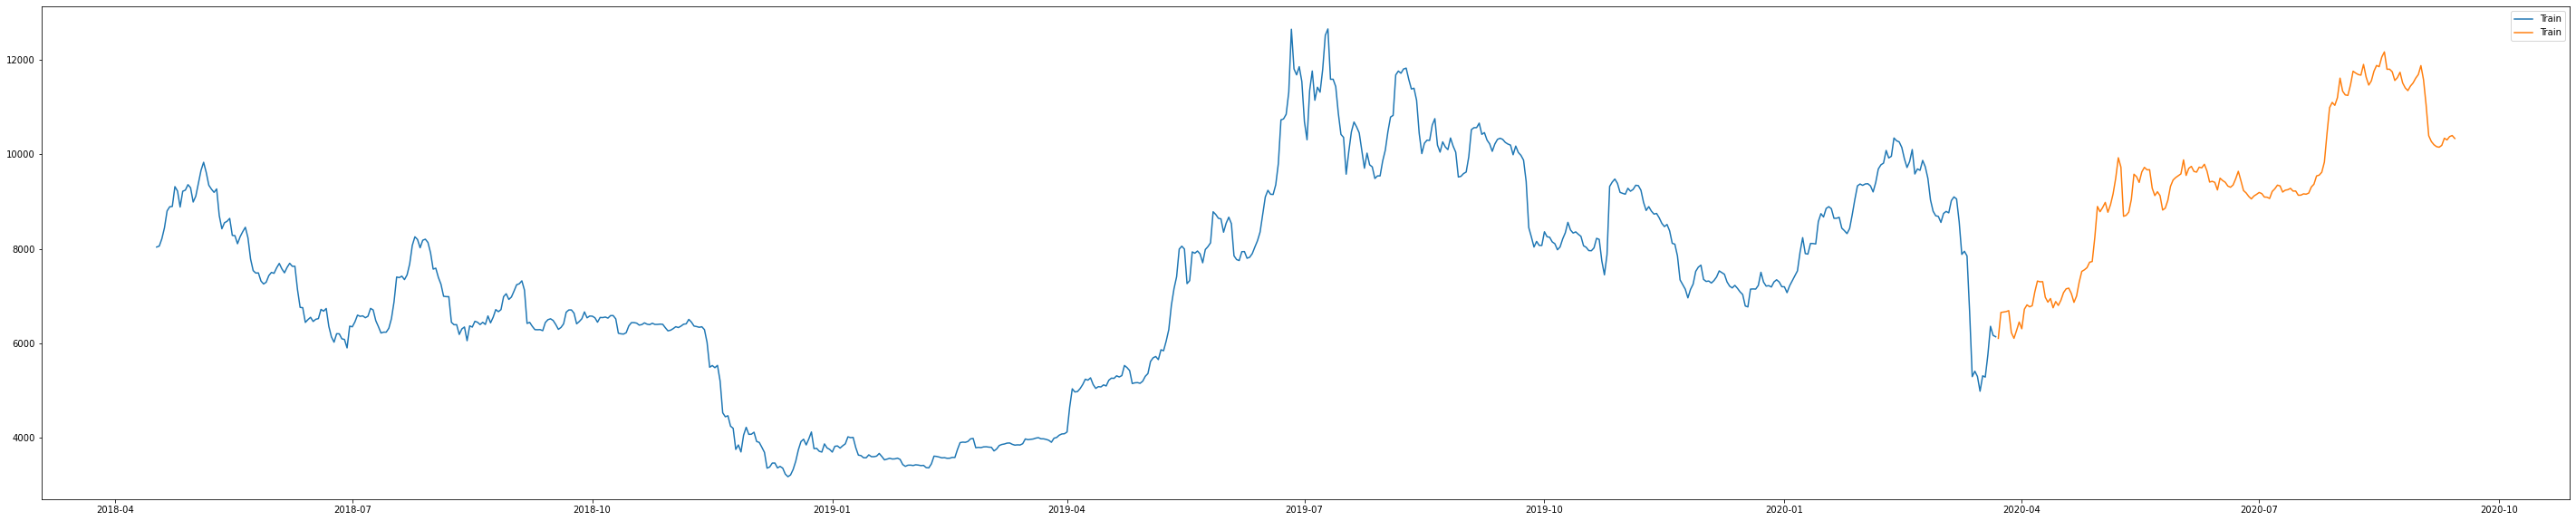

In [16]:
# plot the split
y_col = "Close"
plt.figure(figsize=(50,10))
plt.plot(train.index, train[y_col], label="Train")
plt.plot(test.index, test[y_col], label="Train") 
plt.legend()

In [17]:
# separate explanatory variables from the target variable in the training set
X_train = train.drop(y_col, axis=1).copy()
y_train = train[[y_col]].copy()
print(X_train.shape, y_train.shape)

(706, 4) (706, 1)


In [18]:
# Preprocessing for keras train dataset

Xscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that all the X data will range from 0 to 1
#Xscaler.fit(X_train)
scaled_X_train = Xscaler.fit_transform(X_train)
Yscaler = MinMaxScaler(feature_range=(0, 1))
#Yscaler.fit(y_train)
scaled_y_train = y_train #Yscaler.fit_transform(y_train)
#scaled_y_train = scaled_y_train.reshape(-1) # remove the second dimention from y so the shape changes from (n,1) to (n,)

#scaled_y_train = np.insert(scaled_y_train, 0, 0)
#scaled_y_train = np.delete(scaled_y_train, -1)

In [19]:
len(scaled_X_train)

706

In [20]:
scaled_X_train.shape

(706, 4)

In [21]:
# using of TimeSeriesGenerator


n_input = 10 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 10# Number of timeseries samples in each batch
generator_train = TimeseriesGenerator(scaled_X_train, scaled_y_train.values, length=n_input, batch_size=b_size)


In [22]:
generator_train[0][0].shape

(10, 10, 4)

In [23]:
X_test = test.drop(y_col, axis=1).copy()
y_test = test[[y_col]].copy()
print(X_test.shape, y_test.shape)

(176, 4) (176, 1)


In [24]:
# Preprocessing for keras test dataset

#Xscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that all the X data will range from 0 to 1
#Xscaler.fit(X_test)
scaled_X_test = Xscaler.transform(X_test)
#Yscaler = MinMaxScaler(feature_range=(0, 1))
#Yscaler.fit(y_train)

scaled_y_test = y_test #Yscaler.transform(y_test) 
#scaled_y_test = scaled_y_test.reshape(-1) # remove the second dimention from y so the shape changes from (n,1) to (n,)

#scaled_y_test = np.insert(scaled_y_test, 0, 0)
#scaled_y_test = np.delete(scaled_y_test, -1)

In [25]:
### generator test dataset
generator_test = TimeseriesGenerator(scaled_X_test, scaled_y_test.values, length=n_input, batch_size=b_size)


In [26]:
generator_test[1]

(array([[[0.28120418, 0.41661236, 1.29357798, 0.33030842],
         [0.16525096, 0.54948171, 0.46330275, 0.37417326],
         [0.08954177, 0.55478344, 0.34862385, 0.38370627],
         [0.05168257, 0.25778305, 0.35779817, 0.37933769],
         [0.21991086, 0.27253964, 0.37155963, 0.38188119],
         [0.18403021, 0.34118456, 0.42201835, 0.41289672],
         [0.13313849, 0.38541989, 0.44495413, 0.43693026],
         [0.12678773, 0.57618361, 0.29357798, 0.43524807],
         [0.16884716, 0.4261484 , 0.22477064, 0.4355932 ],
         [0.0413923 , 0.409409  , 0.30275229, 0.40086392]],
 
        [[0.16525096, 0.54948171, 0.46330275, 0.37417326],
         [0.08954177, 0.55478344, 0.34862385, 0.38370627],
         [0.05168257, 0.25778305, 0.35779817, 0.37933769],
         [0.21991086, 0.27253964, 0.37155963, 0.38188119],
         [0.18403021, 0.34118456, 0.42201835, 0.41289672],
         [0.13313849, 0.38541989, 0.44495413, 0.43693026],
         [0.12678773, 0.57618361, 0.29357798, 0.43524

In [27]:
generator_test[0][0].shape

(10, 10, 4)

In [28]:
n_input

10

# Instancing the model:

In [29]:
leaky = tf.keras.layers.LeakyReLU()


In [30]:
# instancing the model

model2 = Sequential([
    LSTM(units=128, return_sequences= True, input_shape=(n_input, n_features)),
    LSTM(units=32, return_sequences=False),
    Dense(units=16),#, activation="relu"),
    #Dropout(0.1),
    leaky,
    Dense(units=32),#, activation="relu"),
    leaky,
    # if we have 20% are dead cless to avoid overfitting and creat better models
    #model.add(LSTM(units=100, return_sequences=True))
    # inputshape is only defined in the first layer
    # the model is smart enough to understand which data to fit in the next layer
    #model.add(Dropout(0.2))
    # 0.2, 96 are hyperparameters
    #model.add(LSTM(units=100))
    #model2.add(Dropout(0.1)),
    #normal layer
    #model.add(Dense(units=1))
    #Dropout(0.2),
    Dense(units=1)
])

In [31]:
model2.trainable_variables[-1].assign(y_train.mean())

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([7176.548], dtype=float32)>

In [32]:
# compiling
opti = tf.keras.optimizers.Adam(1e-3)
model2.compile(optimizer=opti, loss= tf.keras.losses.MAPE)
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 128)           68096     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 89,809
Trainable params: 89,809
Non-trainable params: 0
____________________________________________________

In [33]:
model2.fit_generator(generator_train, validation_data=generator_test ,epochs=200)
   

/Applications/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
70/70 [==============================] - 4s 27ms/step - loss: 28.8510 - val_loss: 23.7146
Epoch 2/200
70/70 [==============================] - 1s 11ms/step - loss: 24.5409 - val_loss: 23.6650
Epoch 3/200
70/70 [==============================] - 1s 10ms/step - loss: 27.4196 - val_loss: 23.5161
Epoch 4/200
70/70 [==============================] - 1s 11ms/step - loss: 39.9128 - val_loss: 22.4807
Epoch 5/200
70/70 [==============================] - 1s 10ms/step - loss: 28.9131 - val_loss: 21.2804
Epoch 6/200
70/70 [==============================] - 1s 10ms/step - loss: 31.0482 - val_loss: 20.4831
Epoch 7/200
70/70 [==============================] - 1s 10ms/step - loss: 24.7238 - val_loss: 18.4484
Epoch 8/200
70/70 [==============================] - 1s 10ms/step - loss: 19.0389 - val_loss: 16.2352
Epoch 9/200
70/70 [==============================] - 1s 11ms/step - loss: 22.7852 - val_loss: 16.0236
Epoch 10/200
70/70 [==============================] - 1s 12ms/step - loss: 14.5508

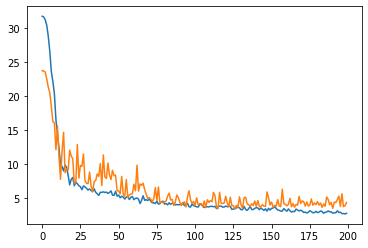

In [34]:
loss_per_epoch = model2.history.history["loss"]
val_loss_per_epoch = model2.history.history["val_loss"]
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
plt.plot(range(len(val_loss_per_epoch)),val_loss_per_epoch)

In [35]:
y_pred_test = model2.predict(generator_test)


In [36]:
y_pred_train = model2.predict(generator_train)

In [37]:
X_train

,Volume_(BTC),Polarity,tweet_volum,close_delay
Timestamp,,,,
2018-04-17,6.442466,0.144570,129.0,8080.020306
2018-04-18,6.407781,0.079355,88.0,8036.633618
2018-04-19,6.560626,0.107818,94.0,8057.312993
2018-04-20,11.152516,0.103734,75.0,8213.263314
2018-04-21,10.650214,-0.000860,63.0,8445.635604
...,...,...,...,...
2020-03-18,15.750551,0.138790,107.0,5313.417317
2020-03-19,17.314484,0.127755,92.0,5286.562181
2020-03-20,20.950193,0.171504,111.0,5759.508901


In [38]:
X_train.iloc[- len(y_pred_train):,:]

,Volume_(BTC),Polarity,tweet_volum,close_delay
Timestamp,,,,
2018-04-27,7.899663,0.124423,88.0,8883.210299
2018-04-28,10.804446,0.130611,14.0,9217.020847
2018-04-29,7.600349,0.108126,21.0,9240.572972
2018-04-30,5.615061,0.072475,70.0,9356.163624
2018-05-01,8.429350,0.107469,175.0,9290.616042
...,...,...,...,...
2020-03-18,15.750551,0.138790,107.0,5313.417317
2020-03-19,17.314484,0.127755,92.0,5286.562181
2020-03-20,20.950193,0.171504,111.0,5759.508901


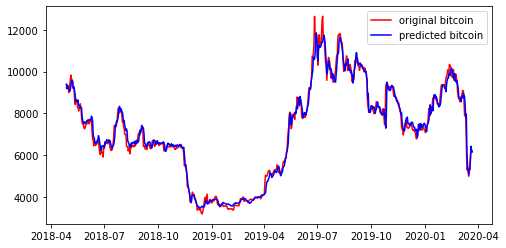

In [39]:
fig, ax = plt.subplots(figsize=(8,4))
plt.plot(X_train.iloc[- len(y_pred_train):,:].index, y_train.iloc[- len(y_pred_train):,:], color='red', label='original bitcoin')
ax.plot(X_train.iloc[- len(y_pred_train):,:].index, y_pred_train, color="blue", label="predicted bitcoin")

plt.legend()
#print(range(len(y_train)+50, len(y_train)+50+len(y_pred_train)))

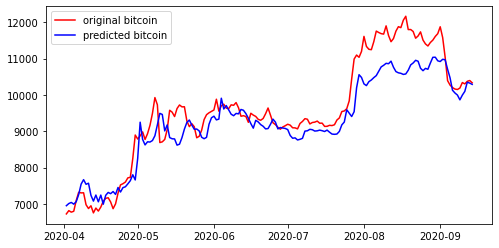

In [40]:
fig, ax = plt.subplots(figsize=(8,4))
plt.plot(X_test.iloc[- len(y_pred_test):,:].index, y_test.iloc[- len(y_pred_test):,:], color='red', label='original bitcoin')
ax.plot(X_test.iloc[- len(y_pred_test):,:].index, y_pred_test, color="blue", label="predicted bitcoin")

plt.legend()

In [41]:
y_pred_test.shape

(166, 1)

In [42]:
y_pred_train.shape

(696, 1)

In [43]:
list1 = y_pred_train.tolist()
list1

[[9394.634765625],
 [9188.2861328125],
 [9305.130859375],
 [9183.1552734375],
 [9151.724609375],
 [9145.9306640625],
 [9055.4541015625],
 [9173.12109375],
 [9406.736328125],
 [9528.18359375],
 [9586.5791015625],
 [9519.2958984375],
 [9185.4931640625],
 [9252.25390625],
 [9091.9521484375],
 [8909.83203125],
 [8575.310546875],
 [8651.2041015625],
 [8564.91796875],
 [8559.4521484375],
 [8631.0556640625],
 [8382.046875],
 [8393.494140625],
 [8262.8466796875],
 [8307.728515625],
 [8278.41015625],
 [8260.6533203125],
 [7823.7841796875],
 [7632.5205078125],
 [7574.31787109375],
 [7504.89306640625],
 [7591.1904296875],
 [7561.1455078125],
 [7527.1650390625],
 [7578.0341796875],
 [7646.35888671875],
 [7651.83544921875],
 [7642.1630859375],
 [7680.6376953125],
 [7693.9375],
 [7701.9970703125],
 [7640.73974609375],
 [7716.80859375],
 [7863.478515625],
 [7791.7724609375],
 [7619.9248046875],
 [6962.4736328125],
 [6846.62939453125],
 [6780.72412109375],
 [6565.70458984375],
 [6604.314453125],
 [660

In [44]:
list1 =y_pred_train.ravel().tolist()
list1
list2 =y_pred_test.ravel().tolist()
list2
list3= list1 +list2 
list3

[9394.634765625,
 9188.2861328125,
 9305.130859375,
 9183.1552734375,
 9151.724609375,
 9145.9306640625,
 9055.4541015625,
 9173.12109375,
 9406.736328125,
 9528.18359375,
 9586.5791015625,
 9519.2958984375,
 9185.4931640625,
 9252.25390625,
 9091.9521484375,
 8909.83203125,
 8575.310546875,
 8651.2041015625,
 8564.91796875,
 8559.4521484375,
 8631.0556640625,
 8382.046875,
 8393.494140625,
 8262.8466796875,
 8307.728515625,
 8278.41015625,
 8260.6533203125,
 7823.7841796875,
 7632.5205078125,
 7574.31787109375,
 7504.89306640625,
 7591.1904296875,
 7561.1455078125,
 7527.1650390625,
 7578.0341796875,
 7646.35888671875,
 7651.83544921875,
 7642.1630859375,
 7680.6376953125,
 7693.9375,
 7701.9970703125,
 7640.73974609375,
 7716.80859375,
 7863.478515625,
 7791.7724609375,
 7619.9248046875,
 6962.4736328125,
 6846.62939453125,
 6780.72412109375,
 6565.70458984375,
 6604.314453125,
 6609.7958984375,
 6573.54150390625,
 6647.20361328125,
 6762.890625,
 6930.33203125,
 6820.0419921875,
 66

In [45]:
len(list3)

862

In [46]:
#from datetime import datetime
#a_date = datetime.date(2015, 10, 10)
#days = datetime.delta(days=5)

#new_date = a_date - days
#print(new_date)

In [47]:
results_predictions = pd.DataFrame({'data':pd.date_range(end='14-09-2020',periods=862),'y_pred':list3})

In [48]:
results_predictions

,data,y_pred
0,2018-05-07,9394.634766
1,2018-05-08,9188.286133
2,2018-05-09,9305.130859
3,2018-05-10,9183.155273
4,2018-05-11,9151.724609
...,...,...
857,2020-09-10,9992.753906
858,2020-09-11,10095.508789
859,2020-09-12,10347.419922
860,2020-09-13,10323.685547


In [49]:
results_predictions.to_csv("results_LSTM.csv")